# Разработка системы определения негативных рецензий

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag

import warnings

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')     
except:
    df = pd.read_csv('c:/Users/User/Downloads/toxic_comments.csv')

Посмотрим на данные

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
df.isnull().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe(include='object')

,text
count,159292
unique,159292
top,Explanation\nWhy the edits made under my usern...
freq,1


Посмортим на баланс классов

In [9]:
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print('Ratio:',class_ratio)

toxic
0    143106
1     16186
Name: count, dtype: int64

Ratio: 8.841344371679229


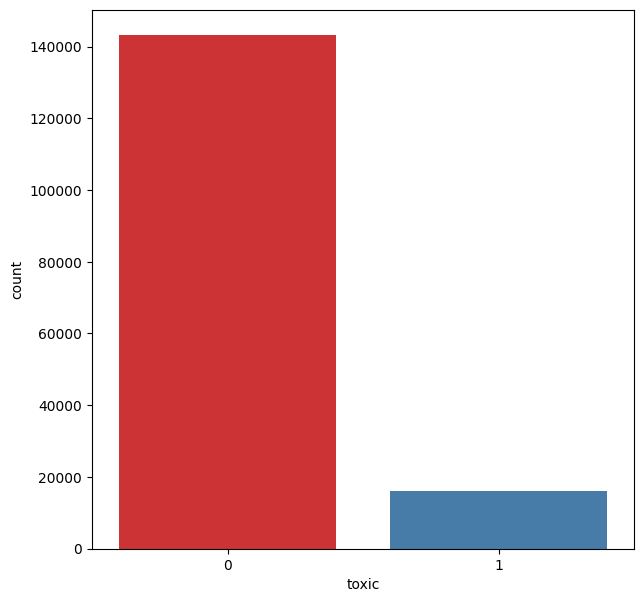

In [10]:
plt.figure(figsize=(7, 7))
sns.countplot(x='toxic', data=df, palette="Set1");

Вывод: Набор данных всего содержит 159292 строк и 3 столбца. Результаты:

- В данных нет пропущенных значений и дубликатов
- Язык текста комментариев - английский
- В тексте комментариев содержатся разные регистры букв, символы пунктуации и '/n' итд.
- Найден дисбаланс классов в соотношении примерно 1:8

#### Предобработка данных

**Лемматизация**

Приведение текста в столбце 'text' к нижнему регистру

In [11]:
df['text'] = df['text'].str.lower()

In [12]:
df.duplicated().sum()

0

Объявим корпус текстов, переведем его в тип юникод

In [13]:
corpus = df['text'].values
print(corpus[0])

explanation
why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27


Для обработки текста, объявим лемматизатор и функцию для очистки и лемматизации текстов

In [14]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,               #прилагательное
                "N": wordnet.NOUN,              #существительное
                "V": wordnet.VERB,              #глагол
                "R": wordnet.ADV                #наречие
               }  
    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()

def lemmatize_text(text):
    text = [wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [15]:
df.head(10)

,Unnamed: 0,text,toxic
0,0,explanation\nwhy the edits made under my usern...,0
1,1,d'aww! he matches this background colour i'm s...,0
2,2,"hey man, i'm really not trying to edit war. it...",0
3,3,"""\nmore\ni can't make any real suggestions on ...",0
4,4,"you, sir, are my hero. any chance you remember...",0
5,5,"""\n\ncongratulations from me as well, use the ...",0
6,6,cocksucker before you piss around on my work,1
7,7,your vandalism to the matt shirvington article...,0
8,8,sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


**Разделение данных на выборки**

In [16]:
target = df['toxic']
features = df.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345)

In [17]:
print(target_train.shape)
print(features_train.shape)

(95575,)
(95575, 2)


Загрузим стоп-слова

In [18]:
stop_words = list(nltk_stopwords.words('english'))

Объявление TFIDF-векторизатора

In [19]:
count_tfidf = TfidfVectorizer(stop_words=stop_words)

Расчет tfdif в каждой из выборок по признаков с типом данных Unicode

In [20]:
features_train = count_tfidf.fit_transform(features_train['text'])
features_valid = count_tfidf.transform(features_valid['text'])
features_test = count_tfidf.transform(features_test['text'])

In [21]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

(95575, 138347)
(31858, 138347)
(31859, 138347)


**Ресемплирование**

Ранее было обнаружено, что классы в данных несбалансированы. Для балансировки классов уменьшим количество значений в классе 0 (downsampling) метод. Увеличение класса 1 использовать не будем из-за большого объема данных.

Балансировка target_train 

In [22]:
toxic_comments_train = df.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

Балансировка features_train 

In [23]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tfidf.transform(features_train_downsample['text']
                                                   .values.astype('U'))

In [24]:
print(target_train.shape)
print(features_train.shape)

(95575,)
(95575, 138347)


Вывод: 
В ходе преподготовки признаки были разделены на обучающую, валидационную и тестовую выборки. Текст комментариев приведен к нижнему регистру, удалены дубликаты, сбалансированы классы.

## Обучение

Нам необходимо эффективно подобрать наиболее эффективную модель, то есть проанализировать несколько модели и сравнить их RMSE моделей (оценка качества) и выбрать ту которая наиболее близка к нулю. Также отследим время обучения моделей. Мы обучим и проанализируем следующие модели:

- LogisticRegression
- Random Forest
- CatBoostClassifier

**Logistic Regression классификатор**

In [25]:
%%time
dict_classes={0:1, 1:8.84}
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=5)
clf.fit(features_train, target_train)
LR_best_params = clf.best_params_
print(LR_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

{'C': 10, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'liblinear'}
0.713172 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'newton-cg'}
0.713262 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'lbfgs'}
0.713075 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'liblinear'}
0.756007 for {'C': 1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'newton-cg'}
0.756044 for {'C': 1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'lbfgs'}
0.755994 for {'C': 1, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'liblinear'}
0.764526 for {'C': 10, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'newton-cg'}
0.764262 for {'C': 10, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'lbfgs'}
0.764590 for {'C': 10, 'class_weight': {0: 1, 1: 8.84}, 'solver': 'liblinear'}

CPU times: total: 1min 51s
Wall time: 1min 47s


In [26]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7645899653205838
F1 на валидации 0.7670952659263589
CPU times: total: 3.19 s
Wall time: 3.17 s


**Decision Tree классификатор**

In [27]:
%%time

classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30,51,2)],
                'random_state':[12345],
                'class_weight':[dict_classes]}]


clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
DTC_best_params = clf.best_params_
print(DTC_best_params)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

{'class_weight': {0: 1, 1: 8.84}, 'max_depth': 38, 'random_state': 12345}
0.601976 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 30, 'random_state': 12345}
0.606774 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 32, 'random_state': 12345}
0.605772 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 34, 'random_state': 12345}
0.609333 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 36, 'random_state': 12345}
0.615445 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 38, 'random_state': 12345}
0.610799 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 40, 'random_state': 12345}
0.602086 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 42, 'random_state': 12345}
0.596457 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 44, 'random_state': 12345}
0.602152 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 46, 'random_state': 12345}
0.604612 for {'class_weight': {0: 1, 1: 8.84}, 'max_depth': 48, 'random_state': 12345}
0.606730 for {'class_weight': {0: 1, 1: 8.84}, 'max_dept

In [28]:
%%time

classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6154445458545031
F1 на валидации 0.6092171717171716
CPU times: total: 1min
Wall time: 1min


**CatBoost классификатор**

In [29]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=30)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.6911088654599208
F1 на валидации 0.6860619889712872
CPU times: total: 11min
Wall time: 2min 8s


Вывод: Всего было проанализированно 3 модели, среди которых:

Самой лучшей моделью является модель Logistic Regression, F1 этой модели (0.76), F1 Catboost (0.68) , у Decision Tree F1 = 0.61

Для тестирования оставляем модель логистической регрессии.

**Проверка модели на тестовой выборке**

In [30]:
%%time

classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_test)
valid_f1_LR = f1_score(target_test, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на тесте', valid_f1_LR)

F1 на cv 0.7645899653205838
F1 на тесте 0.7596992481203007
CPU times: total: 3.2 s
Wall time: 3.12 s


Прстроим ROC кривую и оценим качество обучения модели

Значение AUC-ROC =  0.8764533508686739


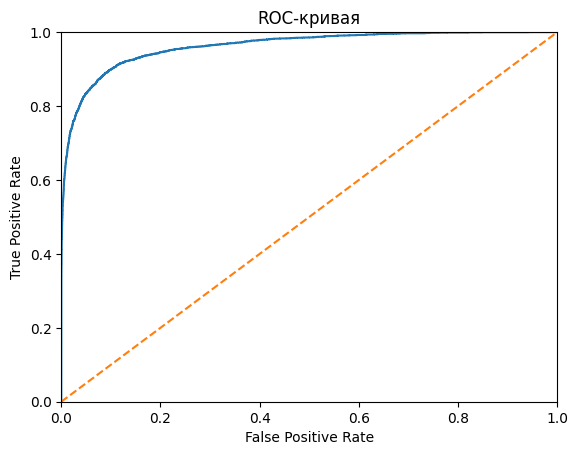

In [31]:
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, target_predict)

print('Значение AUC-ROC = ',auc_roc)



fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Вывод: F1 валидационной и тестовой выборкок = 0.76. Это хороший результат и отсутствие разницы означает, что модель не переобучилась. Логистическая регрессия дала хорогие результаты в ROC AUC метрике. Модель способна обработать больше записей.

## Выводы

В ходе работы над данными было сделано следующее:

1. Подготовленны данные обучения на моделях.
2. Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.
3. Обучены модели и выбраны лучшие из них на валидационной выборке.
4. Показаны параметры качества моделей.
Мы подобрали и построили модель для сортировки токсичных комментариев. Logistic Regression - модель с наилучшим значением F1, равным 0.76 на тестовой выборке и на валидационной.